In [106]:
import collections
import random

import numpy as np

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

class CulturalDiff(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of grid
    seed : int
            random seed
    neighborhoood_size : int, optional
    torus : bool, optional
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """


    def __init__(self, height=20, width=20, seed=None,
                neighborhood_size=1, torus=True):
        super().__init__(seed=seed)
        self.height = height
        self.width = width
        self.neighborhood_size = neighborhood_size

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=torus)
        self.datacollector = DataCollector(model_reporters={'diversity':calculate_nr_of_cultures})

        # Fill grid with agents with random traits
        
        # Note that this implementation does not guarantee some set distribution of traits. 
        # Therefore, examining the effect of minorities etc is not facilitated.
        for (_, x, y) in self.grid.coord_iter():
            profile = np.asarray([self.random.choice([0,1]) for _ in range(4)])
            agent = CulturalDiffAgent((x, y), self, profile)
            self.grid.position_agent(agent, x, y)
            self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.datacollector.collect(self)
        self.schedule.step()


class CulturalDiffAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    profile : ndarray
    
    """
    def __init__(self, pos, model, profile):
        super().__init__(pos, model)
        self.pos = pos
        self.profile = profile
        self.neighborhood_size = model.neighborhood_size
        
    def step(self):
        #For each neighbor, calculate the distance
        neighborhood = self.model.grid.iter_neighborhood(self.pos, True, False, radius = self.neighborhood_size)
        neighbors = self.model.grid.get_cell_list_contents([i for i in neighborhood]) 
        neighbors_similarities = {}
        
        for neighbor in neighbors:
            neighbors_similarities[neighbor] = np.sum(self.profile==neighbor.profile)
        
        # Proportional to this similarity, pick a 'random' neighbor to interact with
        
        chosen_neighbor = self.random.choices(list(neighbors_similarities.keys()), weights=list(neighbors_similarities.values()), k = 1)[0]
    
        # Select a trait that differs between the selected neighbor and self and change that trait in self
        # we are using some numpy boolean indexing to make this short and easy
                                        
        not_same_features = self.profile != chosen_neighbor.profile
        
        if np.any(not_same_features):
            index_for_trait = self.random.choice(np.nonzero(not_same_features)[0])
            self.profile[index_for_trait] = chosen_neighbor.profile[index_for_trait]
                                        
                                        
def traits_to_color(profile):  
    """ Converts the traits of an agent to a list of RGBA values"""
    color = profile.copy().astype(float)
    if color[-1]==0:
        color[-1] = 0.2
    return color


def calculate_nr_of_cultures(model):
    diversity = collections.defaultdict(int)
    for (cell, i, j) in model.grid.coord_iter():
        if cell:
            diversity[tuple(cell.profile)] += 1

    return len(diversity.keys())                                           

<AxesSubplot:>

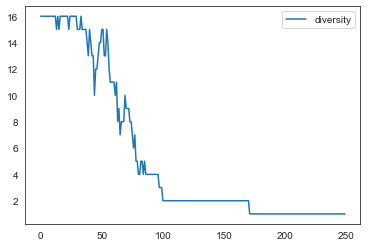

In [107]:
import matplotlib.pyplot as plt

model = CulturalDiff()

for i in range(250):
    model.step()
    
diversity = model.datacollector.get_model_vars_dataframe()
diversity.plot()